In [212]:
import time
from copy import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mixed_naive_bayes import MixedNB
from sklearn import preprocessing, feature_selection, model_selection
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skrebate import ReliefF
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [286]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
all_df = pd.concat([train_df, test_df])

In [431]:
results_df = pd.DataFrame(columns=['f1_score', 'accuracy', 'recall', 'precision'], index=['all_feat', 'pca', 'relieff', 'sfs'])

### Análise característica: Cabin

In [432]:
print(f'Quantidade de missing values na class Cabin {all_df['Cabin'].isna().sum()}')
print(f'Porcentagem de valores vazios na classe Cabin do total de passageiros: {(all_df['Cabin'].isna().sum()/len(all_df['Cabin'])) * 100:.2f}')

Quantidade de missing values na class Cabin 1014
Porcentagem de valores vazios na classe Cabin do total de passageiros: 77.46


Por que remover a classe `Cabin`:
- Muitas instâncias com _missing values_
- Qualquer alternativa de **imputação de valores** iria enviesar muito os valores gerados
- O dado em sí não tem muito "valor"

In [433]:
def pre_process(df):
    df = df.drop(columns=['PassengerId', 'Cabin', 'Name', 'Ticket'])
    df = df.drop_duplicates()

    def _create_family_size_feature(df):
        """ Merge the sibling/spouses and parents/childrens features """
        df['FamilySize'] = df['SibSp'] + df['Parch']
        del df['SibSp']
        del df['Parch']
        return df
        
    def _normalize_features(df):
        num_features = ['Age', 'FamilySize', 'Fare']
        ord_features = ['Pclass']
        passthrough_columns = ['Survived', 'Sex', 'Embarked']
        
        num_transformer = Pipeline(steps=[
            ('minmax scaler', preprocessing.MinMaxScaler())
        ])
        ord_transformer = Pipeline(steps=[
            ('ordinal encoder', preprocessing.OrdinalEncoder())
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                (
                    'normalize numerical features',
                    num_transformer,
                    num_features
                ),
                (
                    'encode ordinal features',
                    ord_transformer,
                    ord_features
                ),
            ], remainder='passthrough'
        )

        df_normalized = preprocessor.fit_transform(df)

        # Get the passthrough columns (the ones not transformed)
        all_columns = num_features + ord_features + passthrough_columns
        return pd.DataFrame(df_normalized, columns=all_columns)
        
    def _one_hot_encode(df):
        cat_features = ['Sex', 'Embarked']
        subset = df[cat_features]
        enc = preprocessing.OneHotEncoder(sparse_output=False)
        encoded_data = enc.fit_transform(subset)
        encoded_df = pd.DataFrame(encoded_data, columns=enc.get_feature_names_out(cat_features))
        
        encoded_df.reset_index(drop=True, inplace=True)
        df.reset_index(drop=True, inplace=True)
        
        df_combined = pd.concat([df.drop(cat_features, axis=1), encoded_df], axis=1)
        return df_combined

    def _fill_nan_with_mean(df):
        imputer = SimpleImputer(strategy='mean')
        df['Age'] = imputer.fit_transform(df[['Age']])
        return df

    def _remove_outliers(df):
        q = df["Fare"].quantile(0.999)
        df = df[df["Fare"] < q]
        return df
        
    def _drop_na(df):
        df = df.dropna()
        return df

    def _split(df):     
        y = df['Survived']
        del df['Survived']

        # splitting the train df into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            df,
            y,
            test_size = 0.2,
            random_state = 0
        )
        y_train = y_train.astype(int)
        y_test = y_test.astype(int)

        return X_train, X_test, y_train, y_test

    return _split(
        _one_hot_encode(
            _drop_na(
                _remove_outliers(
                    _fill_nan_with_mean(
                        _normalize_features(
                            _create_family_size_feature(df)
                        )
                    )
                )
            )
        )
    )

In [434]:
X_train, X_test, y_train, y_test = pre_process(train_df)

In [435]:
X_train_with_label = copy(X_train)
X_train_with_label['Survived'] = y_train

In [436]:
skf = StratifiedKFold(n_splits=10, shuffle=True)
K_FOLD = 10

### Análise de característica: Age

Quantidade de valores vazios na característica age: 263
Média de idade: 29.88


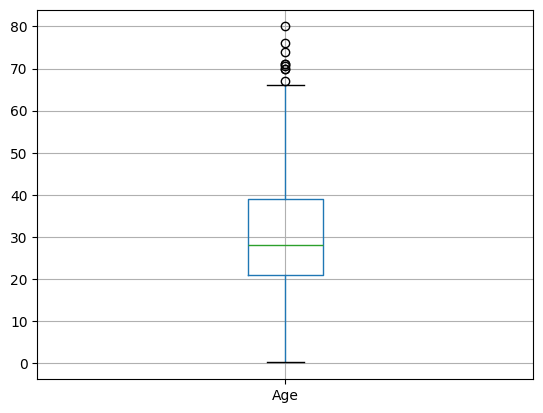

In [437]:
print(f'Quantidade de valores vazios na característica age: {all_df['Age'].isna().sum()}')
print(f'Média de idade: {all_df['Age'].mean():.2f}')
all_df.boxplot(['Age'])
plt.show()

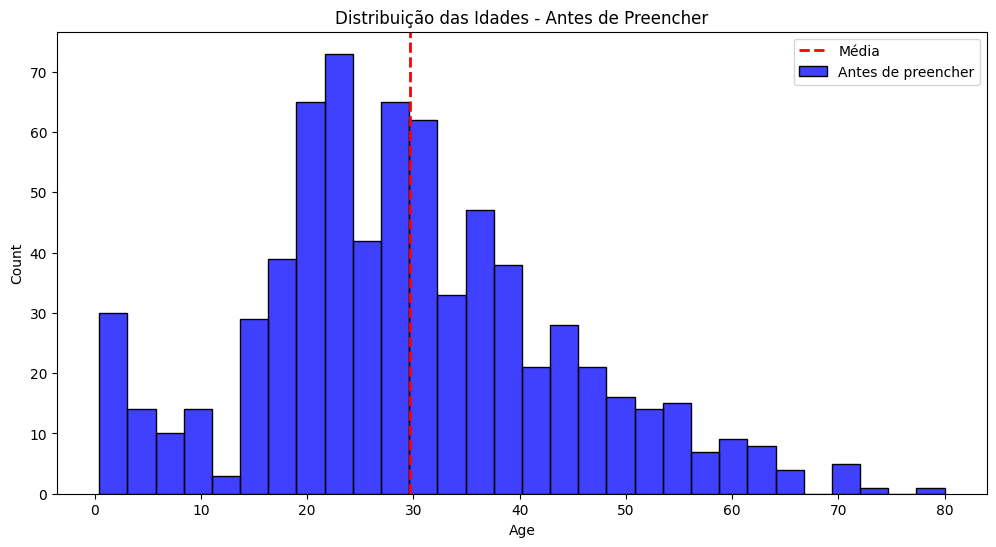

In [438]:
# Plotar histograma antes de preencher os valores nulos
plt.figure(figsize=(12, 6))
sns.histplot(train_df['Age'], bins=30, kde=False, color='blue', label='Antes de preencher')
plt.axvline(train_df['Age'].mean(), color='red', linestyle='dashed', linewidth=2, label='Média')
plt.title('Distribuição das Idades - Antes de Preencher')
plt.legend()
plt.show()

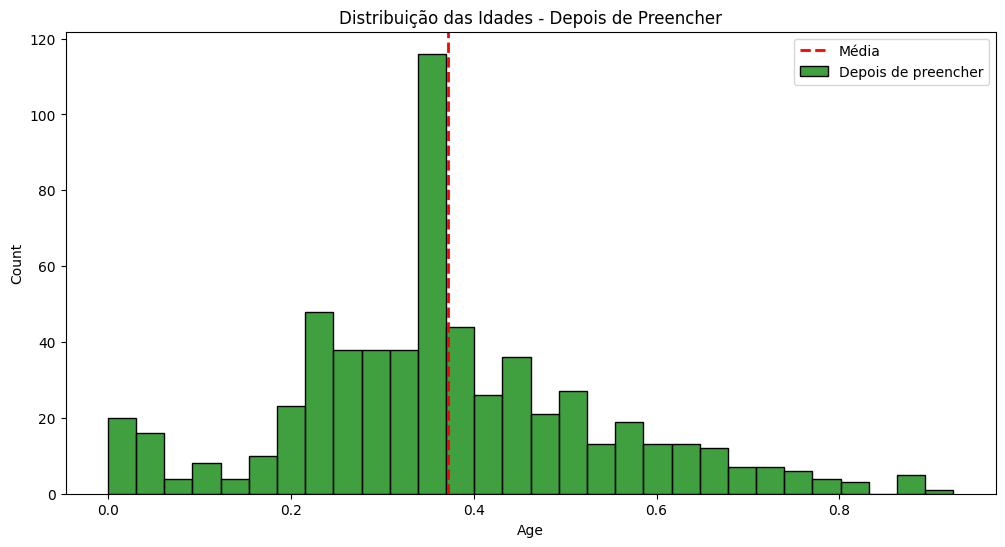

In [439]:
# Plotar histograma depois de preencher os valores nulos
plt.figure(figsize=(12, 6))
sns.histplot(X_train['Age'], bins=30, kde=False, color='green', label='Depois de preencher')
plt.axvline(X_train['Age'].mean(), color='red', linestyle='dashed', linewidth=2, label='Média')
plt.title('Distribuição das Idades - Depois de Preencher')
plt.legend()
plt.show()

### Análise de outliers

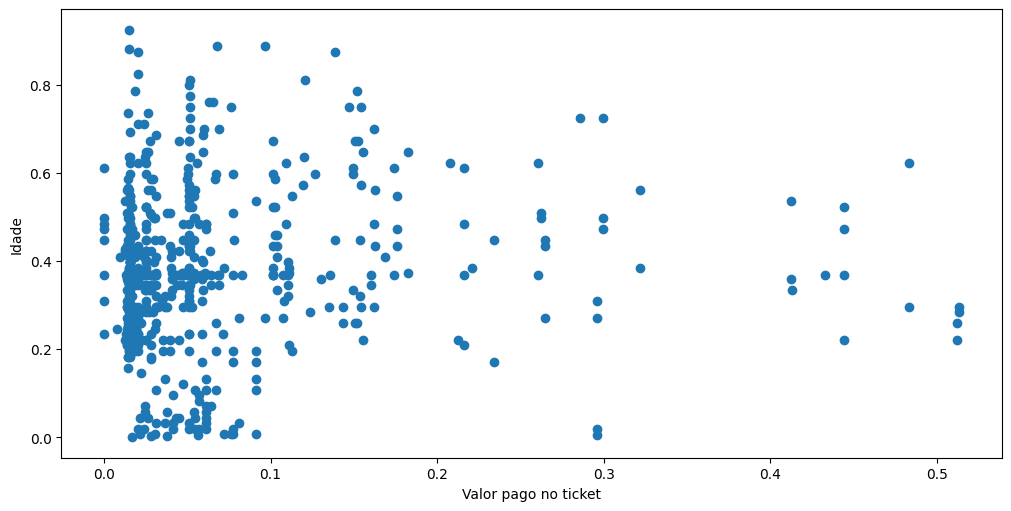

In [440]:
x = X_train['Fare']
y = X_train['Age']

# plot
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')

ax.scatter(x, y)
ax.set_xlabel('Valor pago no ticket')
ax.set_ylabel('Idade')

plt.show()

## Criando nova característica FamilySize

Característica criada a partir de “SibSp” e “Parch”

In [441]:
family_survival_rate = X_train_with_label.groupby('FamilySize')['Survived'].mean().reset_index()

/var/folders/jg/7z54w3515q3fm34byqrlmcl00000gn/T/ipykernel_46727/2773205512.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='FamilySize', y='Survived', data=family_survival_rate, palette='viridis')


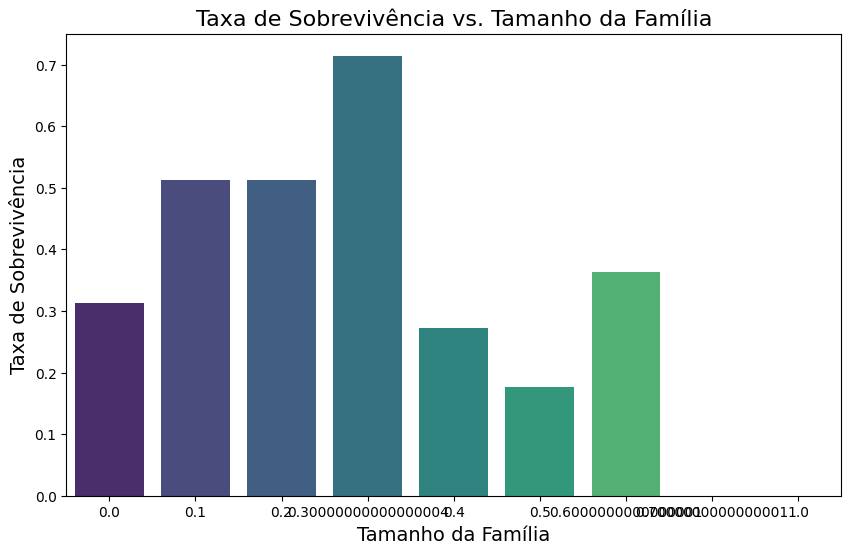

In [442]:
# Plotar o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='FamilySize', y='Survived', data=family_survival_rate, palette='viridis')

# Títulos e rótulos
plt.title('Taxa de Sobrevivência vs. Tamanho da Família', fontsize=16)
plt.xlabel('Tamanho da Família', fontsize=14)
plt.ylabel('Taxa de Sobrevivência', fontsize=14)
plt.show()

## Correlações entre as caracteristicas

In [443]:
correlation_matrix = X_train_with_label.corr() # Pearson's coefficient

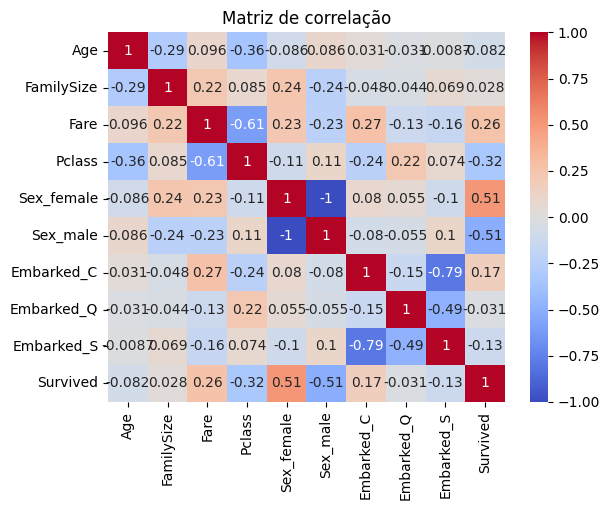

In [444]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlação')
plt.show()

## Redução de dimensionalidade
Executando o algoritmo *RandomForestClassifier* com todas as características do *dataset* para ter uma base de comparação

### Relieff

In [445]:
relieff = ReliefF()
X_train_np = np.asarray(X_train, dtype=np.float32)
relieff.fit(X_train_np, y_train.values);

scores = []
clf_processing_time = []
clf = RandomForestClassifier(n_estimators=100)

# Testing the accuracy each feature
for i in range(1, 10):
    start = time.time()
    new_x = X_train.values[:, relieff.top_features_[:i]]
    scores.append(np.mean(cross_val_score(clf, new_x, y_train.values, scoring='accuracy')))
    end = time.time()
    clf_processing_time.append(end - start)

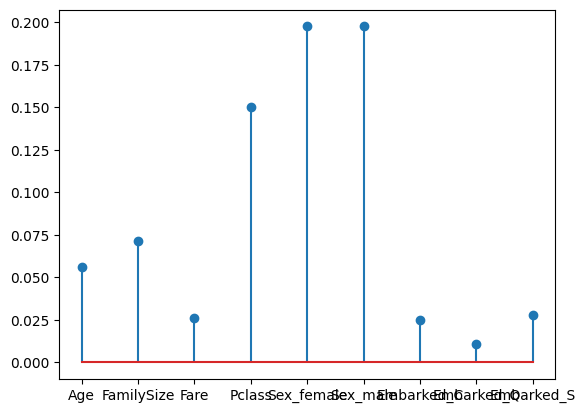

In [446]:
fig, ax = plt.subplots()
ax.stem(X_train.columns, relieff.feature_importances_)
plt.show()

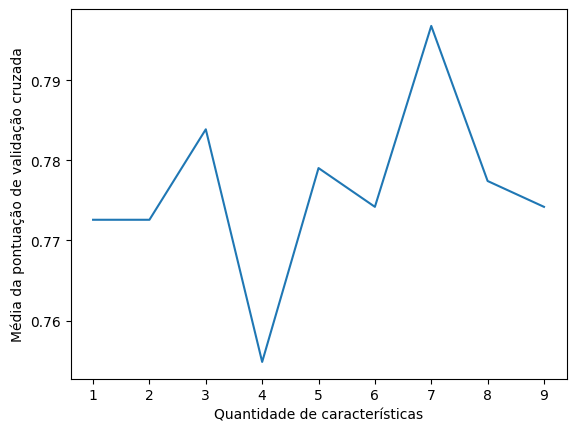

In [447]:
fig, ax = plt.subplots()
ax.plot(list(range(1, 10)), scores)
ax.set_ylabel('Média da pontuação de validação cruzada')
ax.set_xlabel('Quantidade de características')
plt.show()

In [448]:
clf = GaussianNB()
sfs = feature_selection.SequentialFeatureSelector(clf, direction='backward')
skf = StratifiedKFold(n_splits=10)

# sfs_grid_search = model_selection.GridSearchCV(estimator=sfs, param_grid={'n_features_to_select': range(1, 10)}, cv=skf, scoring='accuracy')
# sfs_grid_search.fit(X_train, y_train)

sfs.fit(X_train.values, y_train.values)
sfs_X_train = sfs.transform(X_train)
sfs_X_test = sfs.transform(X_test)

clf.fit(sfs_X_train, y_train)
sfs_y_pred = clf.predict(sfs_X_test)

sfs_f1_score = cross_val_score(clf, sfs_X_train, y_train, cv=K_FOLD, scoring='f1_weighted')
sfs_precision_score = cross_val_score(clf, sfs_X_train, y_train, cv=K_FOLD, scoring='precision')
sfs_recall_score = cross_val_score(clf, sfs_X_train, y_train, cv=K_FOLD, scoring='recall')
sfs_accuracy_score = cross_val_score(clf, sfs_X_train, y_train, cv=K_FOLD, scoring='accuracy')

# clf = GridSearchCV(pca_gnb, parameters)
# clf.fit(df_pca, y_train)

results_df.at['sfs', 'f1_mean'] = np.mean(sfs_f1_score)
results_df.at['sfs', 'f1_std'] = np.std(scores)

results_df.at['sfs', 'precision_mean'] = np.mean(sfs_precision_score)
results_df.at['sfs', 'precision_std'] = np.std(sfs_precision_score)

results_df.at['sfs', 'recall_mean'] = np.mean(sfs_recall_score)
results_df.at['sfs', 'recall_std'] = np.std(sfs_recall_score)

results_df.at['sfs', 'accuracy_mean'] = np.mean(sfs_accuracy_score)
results_df.at['sfs', 'accuracy_std'] = np.std(sfs_accuracy_score)

/Users/lievi/Documents/estudos/mestrado/rec_padroes/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SequentialFeatureSelector was fitted without feature names
  warnings.warn(
/Users/lievi/Documents/estudos/mestrado/rec_padroes/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SequentialFeatureSelector was fitted without feature names
  warnings.warn(


In [449]:
selected_features = [
    feature for feature,
    selected in zip(X_train.columns.values, sfs.get_support())
    if selected is np.True_
]

In [450]:
clf = RandomForestClassifier()
sfs_scores = []
clf_processing_time = []
# Testing the accuracy each feature
for i in range(1, 10):
    start = time.time() 
    sfs = SFS(clf,
          k_features=i, # number of features to select
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=0)
    new_x = sfs.fit_transform(X_train, y_train)    
    sfs_scores.append(np.mean(cross_val_score(clf, new_x, y_train.values, scoring='accuracy', cv=100)))
    end = time.time()
    clf_processing_time.append(end - start)

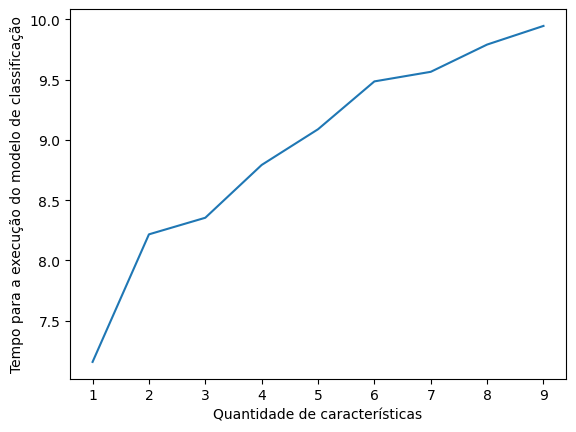

In [451]:
fig, ax = plt.subplots()
ax.plot(list(range(1, 10)), clf_processing_time)
ax.set_ylabel('Tempo para a execução do modelo de classificação')
ax.set_xlabel('Quantidade de características')
plt.show()

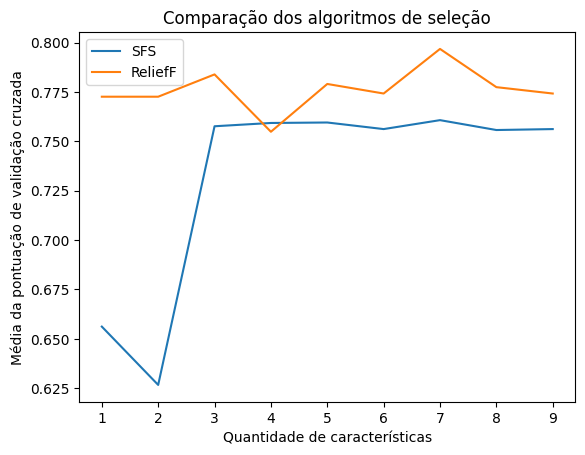

In [452]:
fig, ax = plt.subplots()
ax.plot(list(range(1, 10)), sfs_scores, label='SFS')
ax.plot(list(range(1, 10)), scores, label='ReliefF')
ax.set_ylabel('Média da pontuação de validação cruzada')
ax.set_xlabel('Quantidade de características')
ax.legend()
ax.set_title('Comparação dos algoritmos de seleção')
plt.show()

In [453]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [454]:
# all features classifier
all_feat_clf = MixedNB(categorical_features=[3])
all_feat_clf.fit(X_train.values, y_train.values)
all_feat_y_pred = all_feat_clf.predict(X_test.values)
all_feat_clf.score(X_test, y_test)

all_feat_f1_score = cross_val_score(all_feat_clf, X_train, y_train, cv=K_FOLD, scoring='f1_weighted')
all_feat_precision_score = cross_val_score(all_feat_clf, X_train, y_train, cv=K_FOLD, scoring='precision')
all_feat_recall_score = cross_val_score(all_feat_clf, X_train, y_train, cv=K_FOLD, scoring='recall')
all_feat_accuracy_score = cross_val_score(all_feat_clf, X_train, y_train, cv=K_FOLD, scoring='accuracy')

# clf = GridSearchCV(pca_gnb, parameters)
# clf.fit(df_pca, y_train)

results_df.at['all_feat', 'f1_mean'] = np.mean(all_feat_f1_score)
results_df.at['all_feat', 'f1_std'] = np.std(scores)

results_df.at['all_feat', 'precision_mean'] = np.mean(all_feat_precision_score)
results_df.at['all_feat', 'precision_std'] = np.std(all_feat_precision_score)

results_df.at['all_feat', 'recall_mean'] = np.mean(all_feat_recall_score)
results_df.at['all_feat', 'recall_std'] = np.std(all_feat_recall_score)

results_df.at['all_feat', 'accuracy_mean'] = np.mean(all_feat_accuracy_score)
results_df.at['all_feat', 'accuracy_std'] = np.std(all_feat_accuracy_score)

In [455]:
# relieff selected classifier
RELIEFF_NUM_FEATURES = 6
releaff_X_train = X_train.iloc[:, relieff.top_features_[:RELIEFF_NUM_FEATURES]]
releaff_X_test = X_test.iloc[:, relieff.top_features_[:RELIEFF_NUM_FEATURES]]

In [456]:
relieff_clf = MixedNB(categorical_features=[2])


relieff_clf.fit(releaff_X_train.values, y_train.values)
relieff_y_pred = releaff_clf.predict(releaff_X_test.values)# relieff selected features test accuracy

relieff_f1_score = cross_val_score(relieff_clf, releaff_X_train, y_train, cv=K_FOLD, scoring='f1_weighted')
relieff_precision_score = cross_val_score(relieff_clf, releaff_X_train, y_train, cv=K_FOLD, scoring='precision')
relieff_recall_score = cross_val_score(relieff_clf, releaff_X_train, y_train, cv=K_FOLD, scoring='recall')
relieff_accuracy_score = cross_val_score(relieff_clf, releaff_X_train, y_train, cv=K_FOLD, scoring='accuracy')

# clf = GridSearchCV(pca_gnb, parameters)
# clf.fit(df_pca, y_train)

results_df.at['relieff', 'f1_mean'] = np.mean(relieff_f1_score)
results_df.at['relieff', 'f1_std'] = np.std(scores)

results_df.at['relieff', 'precision_mean'] = np.mean(relieff_precision_score)
results_df.at['relieff', 'precision_std'] = np.std(relieff_precision_score)

results_df.at['relieff', 'recall_mean'] = np.mean(relieff_recall_score)
results_df.at['relieff', 'recall_std'] = np.std(relieff_recall_score)

results_df.at['relieff', 'accuracy_mean'] = np.mean(relieff_accuracy_score)
results_df.at['relieff', 'accuracy_std'] = np.std(relieff_accuracy_score)

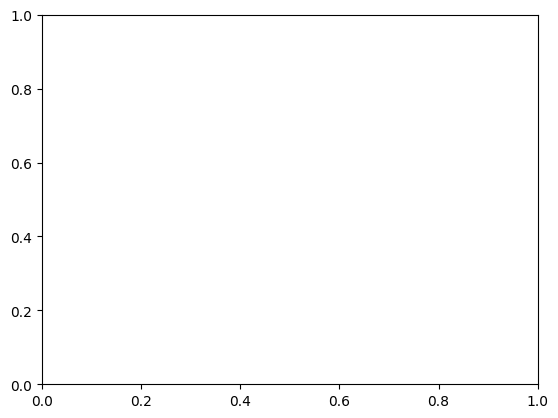

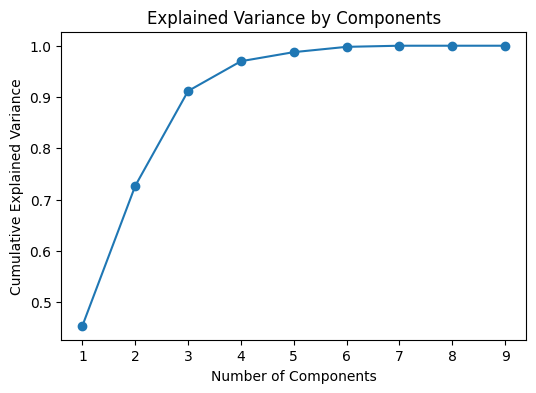

In [458]:
pca = PCA()
X_pca = pca.fit_transform(X_train)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [459]:
# Apply PCA for 4 components
pca = PCA(n_components=4)
principal_components = pca.fit_transform(X_train)  # df should be your original DataFrame
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principal_components_test = pca.fit_transform(X_test)  # df should be your original DataFrame
df_pca_test = pd.DataFrame(data=principal_components_test, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Combine the original DataFrame with the new principal components
df_combined = pd.concat([X_train, df_pca], axis=1)

# Calculate the correlation between the original variables and the principal components
correlation_matrix = pd.DataFrame(index=X_train.columns, columns=df_pca.columns)

for col in X_train.columns:
    for pc in df_pca.columns:
        correlation_matrix.loc[col, pc] = df_combined[col].corr(df_combined[pc])

# Display the correlation matrix
correlation_matrix

,PC1,PC2,PC3,PC4
Age,0.042497,-0.042143,0.05919,-0.039235
FamilySize,-0.064051,0.064226,-0.005774,0.065188
Fare,0.007031,0.063913,0.10091,-0.031992
Pclass,-0.03875,-0.026166,-0.069269,0.002915
Sex_female,-0.004803,0.045398,0.030734,0.071157
Sex_male,0.004803,-0.045398,-0.030734,-0.071157
Embarked_C,-0.039742,-0.003427,-0.00759,0.008908
Embarked_Q,-0.037455,-0.012469,0.007336,-0.087841
Embarked_S,0.058447,0.010804,0.002124,0.046934


In [460]:
pca_gnb = GaussianNB()
pca_f1_score = cross_val_score(pca_gnb, df_pca, y_train, cv=K_FOLD, scoring='f1_weighted')
pca_precision_score = cross_val_score(pca_gnb, df_pca, y_train, cv=K_FOLD, scoring='precision')
pca_recall_score = cross_val_score(pca_gnb, df_pca, y_train, cv=K_FOLD, scoring='recall')
pca_accuracy_score = cross_val_score(pca_gnb, df_pca, y_train, cv=K_FOLD, scoring='accuracy')

# clf = GridSearchCV(pca_gnb, parameters)
# clf.fit(df_pca, y_train)

results_df.at['pca', 'f1_mean'] = np.mean(pca_f1_score)
results_df.at['pca', 'f1_std'] = np.std(scores)

results_df.at['pca', 'precision_mean'] = np.mean(pca_precision_score)
results_df.at['pca', 'precision_std'] = np.std(pca_precision_score)

results_df.at['pca', 'recall_mean'] = np.mean(pca_recall_score)
results_df.at['pca', 'recall_std'] = np.std(pca_recall_score)

results_df.at['pca', 'accuracy_mean'] = np.mean(pca_accuracy_score)
results_df.at['pca', 'accuracy_std'] = np.std(pca_accuracy_score)

# pca_gnb_y_pred = y_pred = gnb.fit(df_pca, y_train).predict(df_pca_test)

## Matriz de confusão

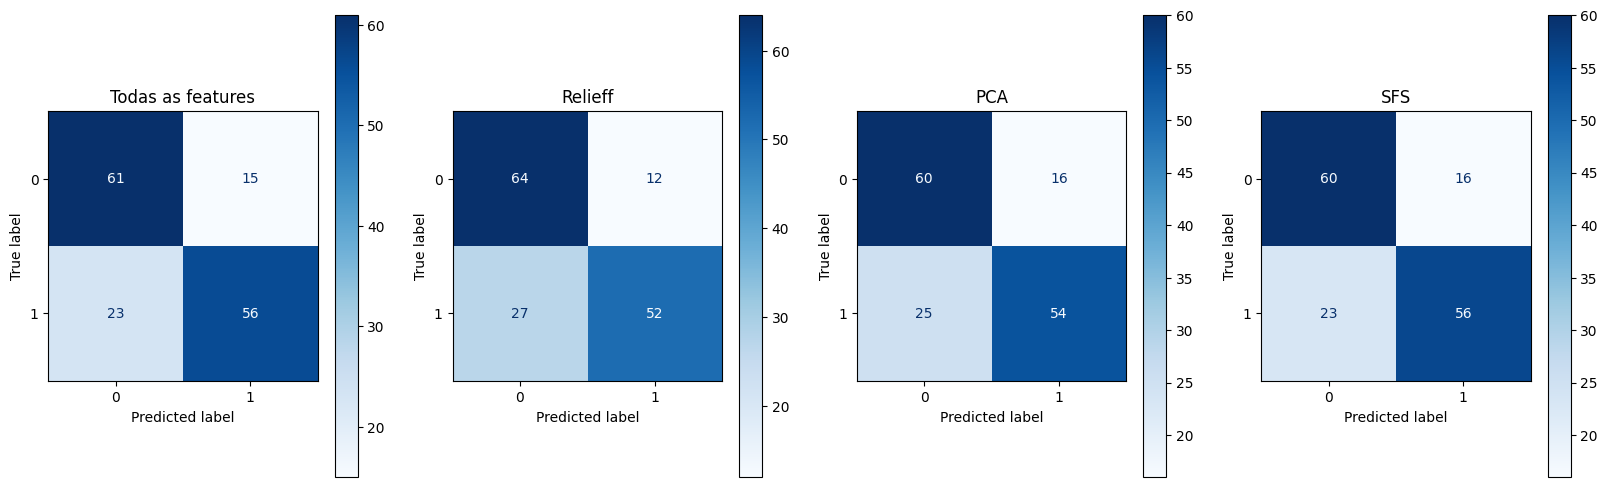

In [484]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,6))

all_feat_conf_matrix = metrics.confusion_matrix(y_test, all_feat_y_pred)
all_disp = metrics.ConfusionMatrixDisplay(all_feat_conf_matrix)
all_disp.plot(cmap=plt.cm.Blues, ax=ax0)
ax0.set_title('Todas as features')

relieff_conf_matrix = metrics.confusion_matrix(y_test, relieff_y_pred)
relieff_disp = metrics.ConfusionMatrixDisplay(relieff_conf_matrix)
relieff_disp.plot(cmap=plt.cm.Blues, ax=ax1)
ax1.set_title('Relieff')

pca_conf_matrix = metrics.confusion_matrix(y_test, pca_gnb_y_pred)
pca_disp = metrics.ConfusionMatrixDisplay(pca_conf_matrix)
pca_disp.plot(cmap=plt.cm.Blues, ax=ax2)
ax2.set_title('PCA')

sfs_conf_matrix = metrics.confusion_matrix(y_test, sfs_y_pred)
sfs_disp = metrics.ConfusionMatrixDisplay(sfs_conf_matrix)
sfs_disp.plot(cmap=plt.cm.Blues, ax=ax3)
ax3.set_title('SFS')

plt.show()

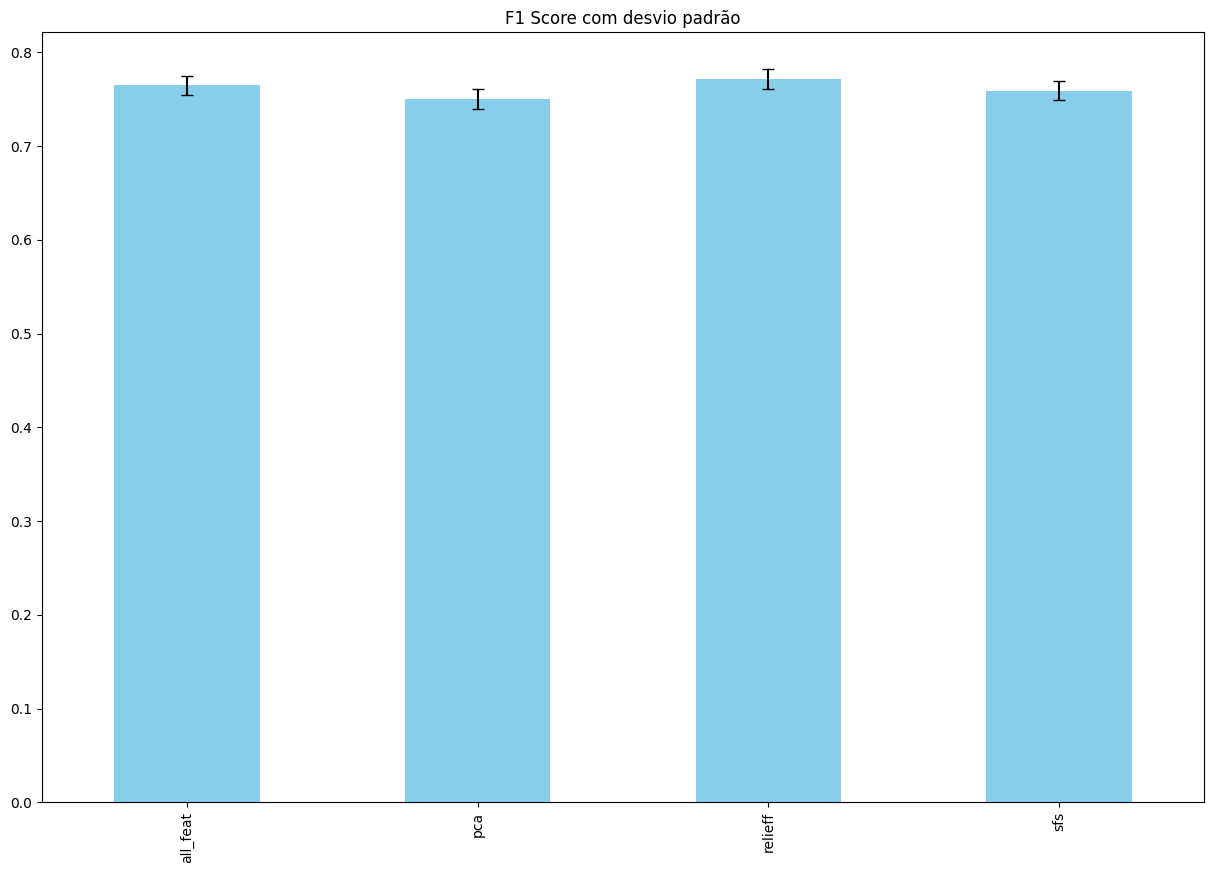

In [462]:
ax0 = results_df['f1_mean'].plot(kind='bar', yerr=results_df['f1_std'], 
                                 figsize=(15, 10), 
                                 title='F1 Score com desvio padrão', 
                                 capsize=4, 
                                 color='skyblue',
                                 legend=False)

# Adicionar rótulos aos eixos
plt.show()

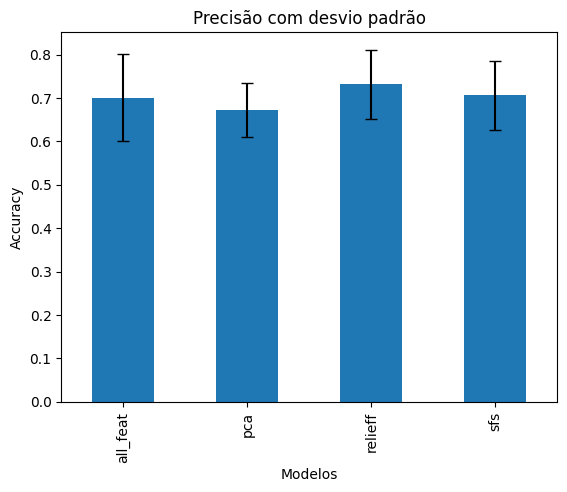

In [463]:
ax = results_df['precision_mean'].plot(kind='bar', yerr=results_df['precision_std'], 
                                 figsize=(15, 10), 
                                 title='Precisão com desvio padrão', 
                                 capsize=4,
                                 legend=False)

# Adicionar rótulos aos eixos
ax.set_ylabel('Accuracy')
ax.set_xlabel('Modelos')
plt.show()

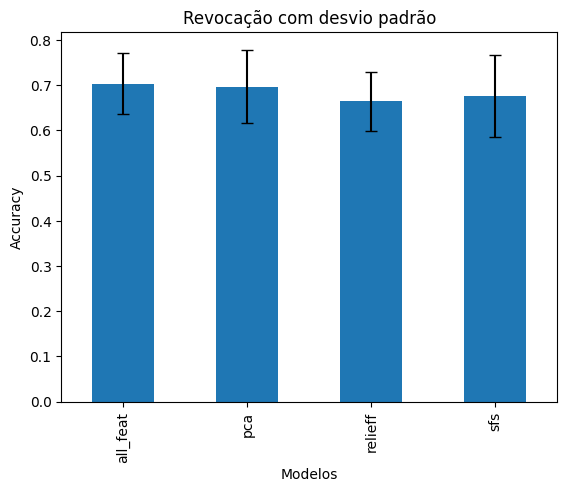

In [464]:
ax = results_df['recall_mean'].plot(kind='bar', yerr=results_df['recall_std'], 
                                 figsize=(15, 10), 
                                 title='Revocação com desvio padrão', 
                                 capsize=4,
                                 legend=False)

# Adicionar rótulos aos eixos
ax.set_ylabel('Accuracy')
ax.set_xlabel('Modelos')
plt.show()

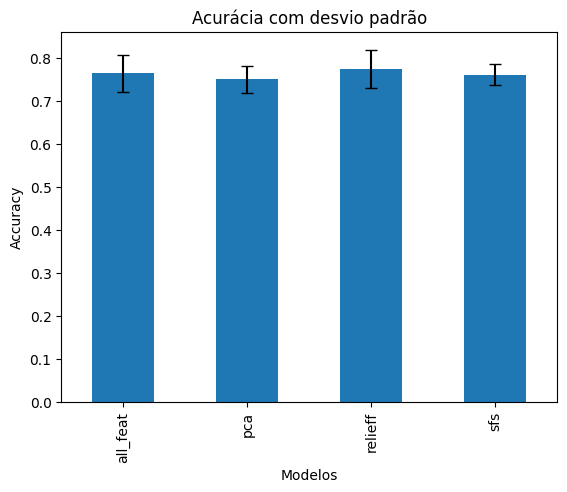

In [465]:
ax = results_df['accuracy_mean'].plot(kind='bar', yerr=results_df['accuracy_std'], 
                                 #figsize=(15, 10), 
                                 title='Acurácia com desvio padrão', 
                                 capsize=4,
                                 legend=False)

# Adicionar rótulos aos eixos
ax.set_ylabel('Accuracy')
ax.set_xlabel('Modelos')
plt.show()

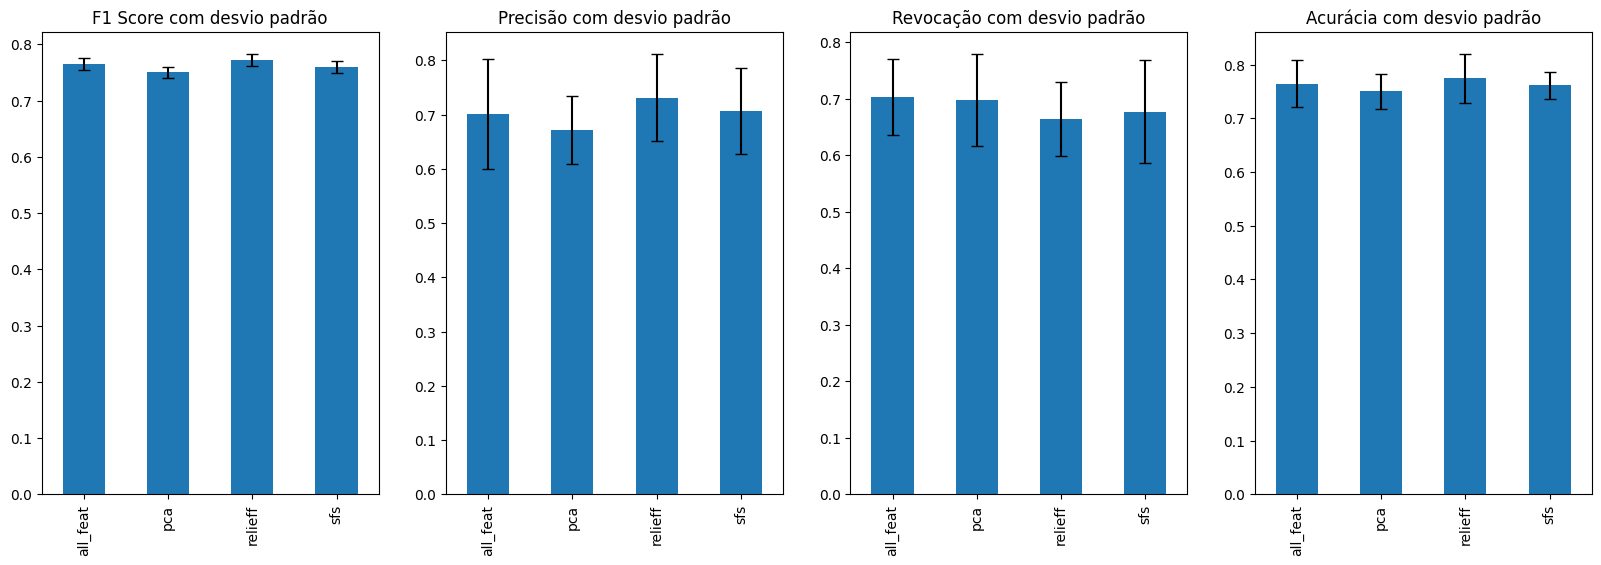

In [466]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,6))

results_df['f1_mean'].plot(kind='bar', yerr=results_df['f1_std'],
                           title='F1 Score com desvio padrão',
                           capsize=4, legend=False, ax=ax0)

results_df['precision_mean'].plot(kind='bar', yerr=results_df['precision_std'],
                                  title='Precisão com desvio padrão',
                                  capsize=4, legend=False, ax=ax1)

results_df['recall_mean'].plot(kind='bar', yerr=results_df['recall_std'], 
                                 title='Revocação com desvio padrão', 
                                 capsize=4,
                                 legend=False, ax=ax2)
results_df['accuracy_mean'].plot(kind='bar', yerr=results_df['accuracy_std'], 
                                 figsize=(15, 10), 
                                 title='Acurácia com desvio padrão', 
                                 capsize=4,
                                 legend=False, ax=ax3)

plt.show()

In [467]:
results_df

,f1_score,accuracy,recall,precision,f1_mean,f1_std,precision_mean,precision_std,recall_mean,recall_std,accuracy_mean,accuracy_std
all_feat,NaN,NaN,NaN,NaN,0.764780,0.010447,0.700769,0.100901,0.703292,0.067121,0.764516,0.043399
pca,NaN,NaN,NaN,NaN,0.750097,0.010447,0.672175,0.062622,0.696920,0.081373,0.750000,0.032459
relieff,NaN,NaN,NaN,NaN,0.771956,0.010447,0.731531,0.079700,0.664155,0.065033,0.774194,0.045046
sfs,NaN,NaN,NaN,NaN,0.759370,0.010447,0.706266,0.079120,0.676812,0.090591,0.761290,0.024778
